In [1]:
import gymnasium as gym # pip install gymnasium gymnasium[classic-control]

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

import matplotlib.pyplot as plt
from IPython import display

# Check Environment

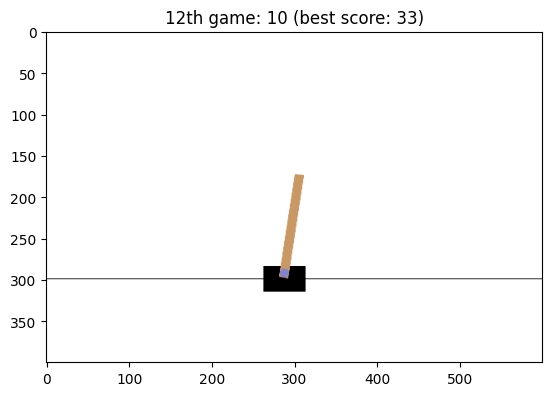

In [2]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
env.reset()
img = plt.imshow(env.render())

n_games, count, best_score = 1, 0, 0 
for _ in range(200):
    count += 1
    
    img.set_data(env.render())
    plt.title(f'{n_games}th game: {count} (best score: {best_score})')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    action = env.action_space.sample() # take a random action
    state, reward, done, truncated, info = env.step(action)
    
    if done or truncated:
        state, info = env.reset()
        if best_score < count:
            best_score = count
        n_games += 1
        count = 0
env.close()

# Hyperparameters

In [3]:
learning_rate = 0.0005
gamma = 0.99

# Model (Policy)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.trajectories = []
        self.fully_connected_layer1 = nn.Linear(4, 64)
        self.fully_connected_layer2 = nn.Linear(64, 2)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
    def forward(self, xb):
        out = self.fully_connected_layer1(xb)
        out = nn.ReLU()(out)
        out = self.fully_connected_layer2(out)
        out = nn.Softmax(dim=0)(out)
        return out
    
    def save_trajectory(self, data):
        self.trajectories.append(data)
        
    def update(self):
        R = 0
        self.optimizer.zero_grad()
        for reward, probability in self.trajectories[::-1]:
            R = reward + gamma*R
            loss = -torch.log(probability)*R
            loss.backward()
        self.optimizer.step()
        self.trajectories = []
        

In [5]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
policy = Net()
total_reward = 0.
    
for n_games in range(2500):
    state, _ = env.reset()
    done = False
        
    while not done:
        probability = policy(torch.from_numpy(state).float())
        m = Categorical(probability)
        action = m.sample()
        next_state, reward, done, truncated, info = env.step(action.item())
        policy.save_trajectory((reward, probability[action]))
            
        state = next_state
        total_reward += reward
        
    policy.update()
        
    if n_games%100 == 0:
        print(f'{n_games}th training => score: {total_reward/100}')
        total_reward = 0.
        
env.close()

0th training => score: 0.19
100th training => score: 18.77
200th training => score: 28.0
300th training => score: 40.43
400th training => score: 51.05
500th training => score: 51.83
600th training => score: 88.03
700th training => score: 134.13
800th training => score: 159.11
900th training => score: 189.54
1000th training => score: 222.7
1100th training => score: 262.45
1200th training => score: 291.77
1300th training => score: 394.84
1400th training => score: 529.27
1500th training => score: 623.86
1600th training => score: 657.04
1700th training => score: 710.35
1800th training => score: 1526.78
1900th training => score: 1935.93
2000th training => score: 4807.02
2100th training => score: 4312.35
2200th training => score: 21369.0
2300th training => score: 1960.36
2400th training => score: 4415.98


# After training

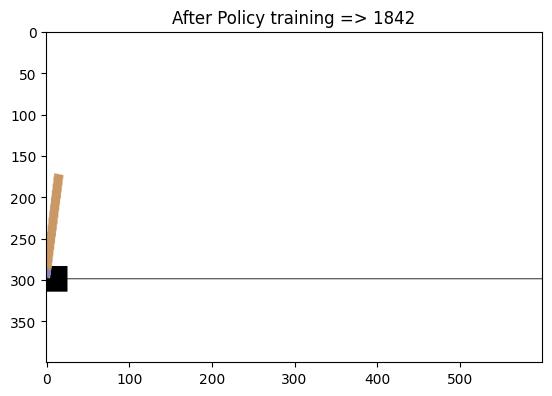

In [6]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
state, _ = env.reset()
img = plt.imshow(env.render())

done, count = False, 0
while not done:
    count += 1
    
    img.set_data(env.render())
    plt.title(f'After Policy training => {count}')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    probability = policy(torch.from_numpy(state).float())
    m = Categorical(probability)
    action = m.sample()
    next_state, reward, done, truncated, info = env.step(action.item())
    state = next_state
    
env.close()